## The purpose of the Capstone 2 project is to determine whether or not the lesion in an image is malignant or not 

### This script loops over the traditional image processing method to produce statistics on malignant and benign lesions ###

Input: image(.jpg)<br>
Output: dictionary (imgname:original img, segmented image,largest contour,area of the largest contour,mask used for segmentation)

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [2]:
%run functions.py

Using TensorFlow backend.
/home/seo/environments/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/seo/environments/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/seo/environments/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/seo/environments/my_env/lib/p

In [1]:
symmetry_dict=dict()
blue_dict=dict()
green_dict=dict()
red_dict=dict()
border_dict=dict()

In [3]:
image_path='./Data/Images/'
imagelist=os.listdir(image_path)
pics=[file for file in imagelist]


import pickle
name="isic_data"
meta_df=pickle.load(open(name,"rb"))

import cv2

In [4]:
j=0
for i in range(j,len(pics)):

    imgname=pics[i]
    filename=image_path+pics[i]
    
    label=imgname.split('.')[0]

    orig_img=cv2.imread(filename, cv2.IMREAD_COLOR)
    img=orig_img

    # normalize image

    norm_image = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

    img=norm_image

    # split image into RGB channels



    r,g,b=split_into_rgb_channels(img)

    
    #reduce noise

    # Do some denoising on blue channel because that usually gives best contrast
    gaussian = cv2.GaussianBlur(b,(3,3),0)


    #find edge & image segmentation

    kernel = np.ones((5,5),np.uint8)
    th, threshed = cv2.threshold(gaussian, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    erosion = cv2.erode(threshed,kernel,iterations = 3)
    dilation = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel)

    cnts, hierarchy=cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE )
    cnts = sorted(cnts, key=cv2.contourArea)
    H,W = img.shape[:2]
    
    maxContour = 0

    for contour in cnts:
        cv2.drawContours(img,contour,-1,(255,0,0),-1)
        contourSize = cv2.contourArea(contour)
        if contourSize > maxContour:
            maxContour = contourSize
            maxContourData = contour
        #if contour
    cv2.drawContours(img,[contour],-1,(255,0,0),-1)

    # Create mask and do bitwise-op
    
    mask = np.zeros(img.shape[:2],np.uint8)
    cv2.drawContours(mask, [contour],-1, 255, -1)
    
    #area = cv2.contourArea(contour)
    dst = cv2.bitwise_and(gaussian, gaussian, mask=mask)
    
    fourcorners=[(0,0),(img.shape[:2][1]-1,0),(0,img.shape[:2][0]-1),(img.shape[:2][1]-1,img.shape[:2][0]-1)]

    orig_cnts=cnts
    new_cnts=list()
    for j in range(len(cnts)):
        try:
            contour=cnts[j]
            bunch=[tuple(contour[num][0]) for num in range(len(contour))]
            y_min=min(bunch, key=lambda t: t[0])[0]
            y_max=max(bunch, key=lambda t: t[0])[0]
            x_min=min(bunch, key=lambda t: t[1])[1]
            x_max=max(bunch, key=lambda t: t[1])[1]

            y_count=0
            x_count=0

            for num in bunch:
                if num[0]==x_min:
                    x_count=x_count+1
                if num[0]==x_max:
                    x_count=x_count+1
                if num[1]==y_min:
                    y_count=y_count+1
                if num[1]==y_max:
                    y_count=y_count+1
            if (x_count>round(img.shape[:2][0]*0.6)) or (y_count>round(img.shape[:2][1]*0.6)):
                cnts.pop(j)
        except:
            continue
    #retread to check if there are removed contour
    for contour in cnts:
        cv2.drawContours(img,contour,-1,(255,0,0),-1)
        contourSize = cv2.contourArea(contour)
        if contourSize > maxContour:
            maxContour = contourSize
            maxContourData = contour
        #if contour
    cv2.drawContours(img,[contour],-1,(255,0,0),-1)
    ## Create mask and do bitwise-op
    mask = np.zeros(img.shape[:2],np.uint8)
    cv2.drawContours(mask, [contour],-1, 255, -1)
    #area = cv2.contourArea(contour)
    dst = cv2.bitwise_and(gaussian, gaussian, mask=mask)

   
    #Check for symmetry: bigger value more malignant

    # get angle and center for rotation
    (a,b),(MA,ma),angle = cv2.fitEllipse(maxContourData)
    a=int(a)
    b=int(b)


    rotated_roi=rotate_bound(dst,angle,a,b)




    from mpl_toolkits.axes_grid1 import AxesGrid

    imageO=rotated_roi
    imageLR=np.fliplr(rotated_roi)
    imageUD=np.flipud(rotated_roi)

    lr=mse(rotated_roi, np.fliplr(rotated_roi),maxContour)
    ud=mse(rotated_roi, np.flipud(rotated_roi),maxContour)

    symmetry_dict[label]=(lr+ud)/2

    #Check Color: bigger value more malignant

    colorcheck = cv2.bitwise_and(orig_img, orig_img, mask=mask)
    #plt.imshow(colorcheck)

    color = ('b','g','r')
    #fig=plt.figure()
    zerovalues=list()
    #ax=fig.add_subplot(2,1,1)
    b_list=[]
    g_list=[]
    r_list=[]
    for i,col in enumerate(color):
        histr = cv2.calcHist([colorcheck],[i],None,[256],[0,256])
        #ax.plot(histr,color = col)
        zerovalues.append(histr[0])
        histr=histr[1:]
        #plt.xlim([0,255])
        #ax.set_yscale('log')
        if col=='b':
            blue_dict[label]=histr.std()
        if col=='g':
            green_dict[label]=histr.std()
        if col=='r':
            red_dict[label]=histr.std()
        #print(histr.std())
    #plt.show()
    #zerovalues
    #print(type(std_list))
    #print(std_list)

    #Check border



    h=20; w=20
    tots_gradient=[]
    for point in maxContourData[:,0]:
        x=point[0]
        y=point[1]
        #print(x,y)
        y1=y-h; y2=y+h
        x1=x-w; x2=x+w
        if y1<0:
            y1=0
        if y2>H:
            y2=H
        if x1<0:
            x1=0
        if x2>W:
            x2=W
        #print(x1,y1,x2,y2)
        crop_img = orig_img[:,:,0][y1:y2, x1:x2].copy()
        mag,ang,gx,gy=get_mag_ang(crop_img)
        tots_gradient.append(mag.mean())

    border_dict[label]=np.mean(tots_gradient)
    j=j+1


print(symmetry_dict,blue_dict,border_dict)

MemoryError: Unable to allocate array with shape (7428, 7992) and data type float64

In [8]:
print(len(symmetry_dict),len(blue_dict),len(green_dict),len(red_dict),len(border_dict))

23906 23906 23906 23906 23906


In [10]:
with open('sym_data.pickle', 'wb') as f:
    pickle.dump(symmetry_dict, f)
with open('b_data.pickle', 'wb') as f:
    pickle.dump(blue_dict, f)
with open('g_data.pickle', 'wb') as f:
    pickle.dump(green_dict, f)
with open('r_data.pickle', 'wb') as f:
    pickle.dump(red_dict, f)
with open('bor_data.pickle', 'wb') as f:
    pickle.dump(border_dict, f)

In [19]:
from collections import defaultdict

dd=defaultdict(list)
for d in (symmetry_dict, border_dict, red_dict, green_dict, blue_dict):
    for key, value in d.items():
        dd[key].append(value)

In [21]:
len(dd)

23906

In [22]:
dd['ISIC_0026298']

[14898.841969644596, 0.757836, 157.46985, 149.20909, 143.30267]

In [29]:
df_raw=pd.DataFrame(dd)
df_raw=df_raw.transpose()
df_raw.columns=['symmetry','border','red','green','blue']

In [30]:
df_raw

,symmetry,border,red,green,blue
ISIC_0003525,2468.394603,3.658589,3119.406250,4482.101562,3844.040039
ISIC_0030102,1065.089562,1.658878,61.765453,102.462532,103.507568
ISIC_0004507,12264.978985,0.667052,228.918793,205.594818,206.782639
ISIC_0012744,0.000000,0.473014,918.462646,901.144653,921.506531
ISIC_0006441,1369.956374,4.721845,9693.034180,5587.845703,5123.171875
ISIC_0034040,4944.630098,1.803269,499.622559,409.853485,382.855591
ISIC_0010324,17413.984884,0.613334,677.432190,655.000793,580.434998
ISIC_0028444,1026.322970,1.695973,284.247314,358.899628,387.579926
ISIC_0005813,4215.326694,4.031921,1990.218994,2740.747803,2414.331299
ISIC_0029842,939.855941,1.862281,133.597260,200.905319,194.316971


In [124]:
ben_mal=meta_df[['name','meta.clinical.benign_malignant']]
ben_mal=ben_mal.rename(columns={'meta.clinical.benign_malignant':'malig_benign'})

In [125]:
ben_mal_list=list()
for malignancy in ben_mal['malig_benign']:
    if malignancy == 'benign':
        ben_mal_list.append(0)
    elif malignancy == 'malignant':
        ben_mal_list.append(1)
    else:
        ben_mal_list.append(np.NaN)

In [126]:
ben_mal['malig_benign']=ben_mal_list

In [128]:
ben_mal=ben_mal.set_index('name')
del ben_mal.index.name

In [129]:
new_df=df_raw.join(ben_mal,how='outer')
new_df=new_df.dropna()

In [130]:
new_df

,symmetry,border,red,green,blue,malig_benign
ISIC_0000000,2139.224486,1.071973,1562.768799,1775.287476,1825.730103,0.0
ISIC_0000001,592.069193,1.629913,232.033493,325.663513,418.763672,0.0
ISIC_0000002,3800.726852,1.092959,1626.993286,1115.725342,943.997864,1.0
ISIC_0000003,1801.773397,1.268437,1046.446289,1120.402100,1477.245361,0.0
ISIC_0000004,1518.183565,2.889020,15109.526367,15048.813477,15048.145508,1.0
ISIC_0000005,4857.512768,2.562840,537.077759,459.008484,494.904938,0.0
ISIC_0000006,1859.872864,1.350611,441.534027,342.003052,303.742035,0.0
ISIC_0000007,1430.180477,1.312029,409.215240,340.098999,322.260010,0.0
ISIC_0000008,1576.905727,1.234047,1182.842773,1071.151978,1353.695557,0.0
ISIC_0000009,1942.445675,1.086488,1076.570557,818.747681,893.308228,0.0


In [131]:
ben=new_df[new_df['malig_benign']==0]
mal=new_df[new_df['malig_benign']==1]

In [132]:
ben.describe()

,symmetry,border,red,green,blue,malig_benign
count,19374.000000,19374.000000,19374.000000,19374.000000,19374.000000,19374.0
mean,2486.361762,1.922132,7398.013682,6881.589481,6239.485158,0.0
std,3466.298374,1.361447,18408.487706,18368.953808,17305.961424,0.0
min,0.000000,0.195523,0.000000,0.062500,0.062500,0.0
25%,817.654879,0.842684,218.560905,218.417454,220.639202,0.0
50%,1522.720293,1.489087,790.709045,723.470947,721.704102,0.0
75%,2770.463882,2.644744,5878.195557,5175.365845,4247.660278,0.0
max,51353.519580,8.174806,380764.281250,399641.500000,344790.437500,0.0


In [133]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [134]:
import matplotlib.pyplot as plt
def ecdf_easy(df,column):
    _mean=np.mean(df[column])
    _std=np.std(df[column])
    _size=round(len(df[column])*0.2)
    samples=np.random.normal(_mean,_std,size=_size)
    
    x_,y_=ecdf(df[column])
    x_norm,y_norm=ecdf(samples)
    
    return x_norm, y_norm
    #plt.plot(x_norm,y_norm)
    #plt.plot(x_,y_, marker='.',linestyle='none')

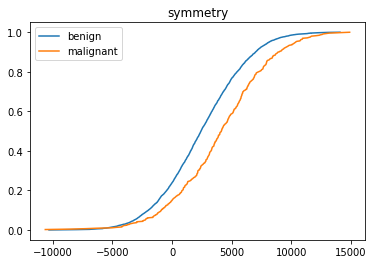

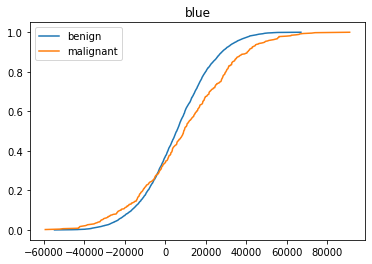

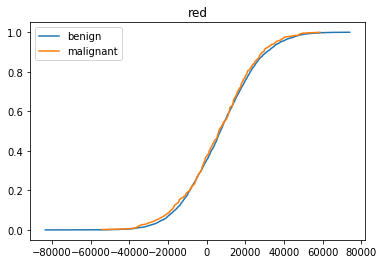

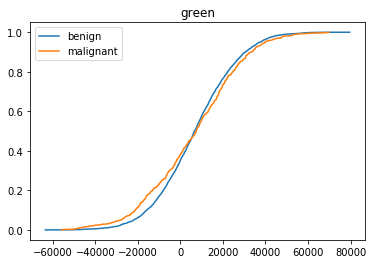

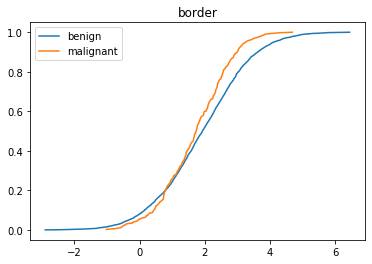

In [135]:
for feature in ['symmetry','blue','red','green','border']:
    xmal,ymal=ecdf_easy(mal,feature)
    xben,yben=ecdf_easy(ben,feature)
    plt.figure()
    plt.plot(xben,yben, label='benign')
    plt.plot(xmal,ymal, label='malignant')
    plt.title(feature)
    plt.legend()

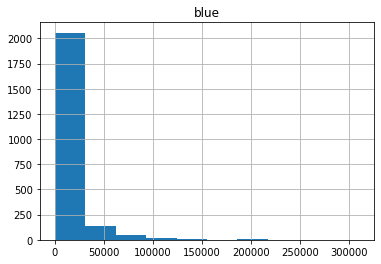

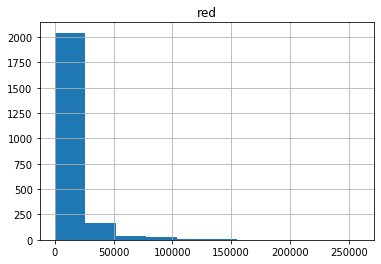

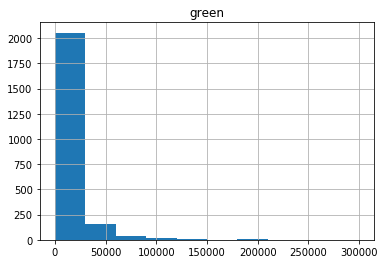

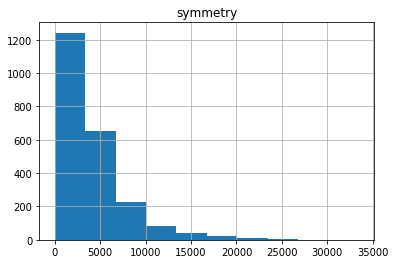

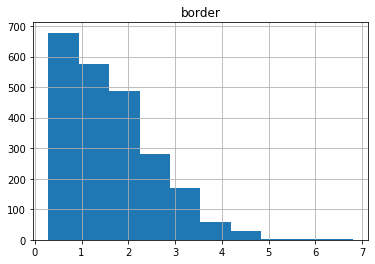

In [136]:
malig_blue=mal.hist('blue')
malig_red=mal.hist('red')
malig_green=mal.hist('green')
malig_sym=mal.hist('symmetry')
malig_bor=mal.hist('border')

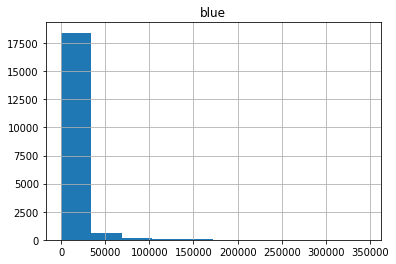

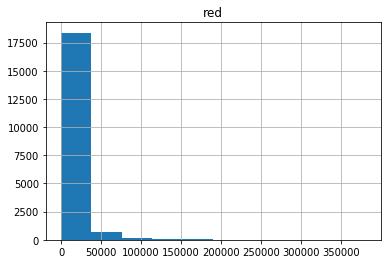

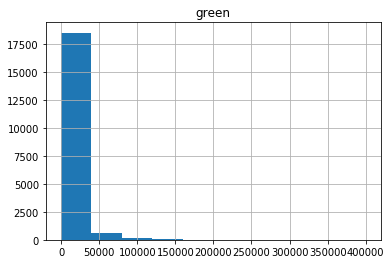

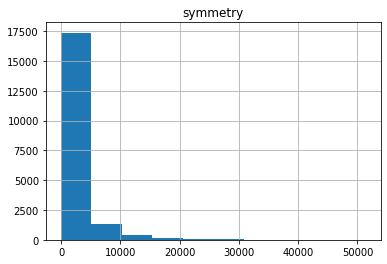

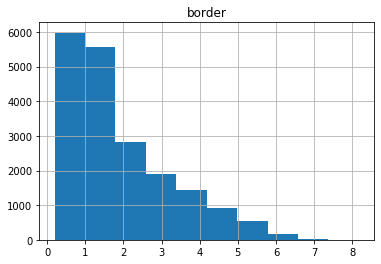

In [137]:
ben_blue=ben.hist('blue')
ben_red=ben.hist('red')
ben_green=ben.hist('green')
ben_sym=ben.hist('symmetry')
ben_bor=ben.hist('border')


In [138]:
from scipy import stats

def check_if_significant(data1,data2,alpha=0.01):
    p_val=stats.ttest_ind(data1,data2)[1]
    if p_val < alpha:
        print('significant ', p_val)
    else:
        print('insignificant ', p_val)

In [139]:
def check_every_element(element):
    return check_if_significant(mal[element],ben[element])

In [140]:
for name in ['symmetry','border','red','green','blue']:
    print(name)
    check_every_element(name)

symmetry
significant  3.010008854171064e-98
border
significant  9.07069449218974e-22
red
insignificant  0.3284638255852935
green
significant  8.525513008172585e-05
blue
significant  2.5564725470129055e-11


In [141]:
from sklearn.model_selection import train_test_split, GridSearchCV
features = new_df.drop('malig_benign',axis=1)
labels = new_df['malig_benign']

In [142]:
feature_list=list(features.columns)
feature_list

['symmetry', 'border', 'red', 'green', 'blue']

In [143]:
import numpy as np
features=np.array(features)

In [144]:
train_features, test_features, train_labels, test_labels = train_test_split(
                                                                    features,
                                                                    labels,
                                                                    test_size = 0.25,
                                                                    random_state=42)

In [145]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (16245, 5)
Training Labels Shape: (16245,)
Testing Features Shape: (5415, 5)
Testing Labels Shape: (5415,)


In [146]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
# number of leaves and dept sensitive
#clf_forest=RandomForestClassifier(n_estimators=100,random_state=42)
clf_forest=RandomForestClassifier(bootstrap=True, class_weight='balanced',
 
criterion='gini', max_depth=9, max_features=0.6,
 
max_leaf_nodes=None, min_impurity_decrease=0.0,
 
min_impurity_split=None, min_samples_leaf=1,
 
min_samples_split=2, min_weight_fraction_leaf=0.0,
 
n_estimators=500, n_jobs=-1, oob_score=False, random_state=0,
 
verbose=0, warm_start=False)
clf_forest_enc=OneHotEncoder(categories='auto')
clf_forest_lm=LogisticRegression(solver='lbfgs',max_iter=1000)

In [147]:
clf_forest.fit(train_features,train_labels)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features=0.6,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [148]:
clf_forest_enc.fit(clf_forest.apply(train_features))

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [149]:
label_pred_forest=clf_forest.predict(test_features)

In [150]:
from sklearn.tree import DecisionTreeClassifier
clf_decision=DecisionTreeClassifier(random_state=42)

In [151]:
clf_decision.fit(train_features,train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [152]:
label_pred_decision=clf_decision.predict(test_features)

In [153]:
import lightgbm as lgb
d_train = lgb.Dataset(train_features, train_labels)
params = {}
params['learning_rate'] = 0.001
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 100
params['min_data'] = 20
params['max_depth'] = 10
clf_lgb = lgb.train(params, d_train, 10000)

In [154]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
y_pred=clf_lgb.predict(test_features)
max_recall=0
thresh=0
for i in range(0,len(test_features)):
    if y_pred[i]>=0.2:       # setting threshold to .5
        y_pred[i]=1
    else:  
        y_pred[i]=0    
recall = recall_score(y_pred, test_labels)
accuracy = accuracy_score(y_pred, test_labels)
    #recall = accuracy_score(y_pred, test_labels)

print("lightgbm Recall:",recall_score(test_labels, y_pred) )
print("lightgbm Accuracy:",accuracy_score(test_labels, y_pred))
print("lightgbm Precision:",precision_score(test_labels, y_pred))
print("lightgbm ROC AUC score:",roc_auc_score(test_labels, y_pred))

lightgbm Recall: 0.4855072463768116
lightgbm Accuracy: 0.8371191135734072
lightgbm Precision: 0.3094688221709007
lightgbm ROC AUC score: 0.6812689429498698


In [155]:
pd.DataFrame(sorted(zip(clf_lgb.feature_importance(),feature_list)),columns=['Value','Feature'])

,Value,Feature
0,171726,green
1,177411,blue
2,183399,symmetry
3,192070,border
4,196746,red


In [156]:
from sklearn import metrics
print("Random forest Recall:",metrics.recall_score(test_labels, label_pred_forest))
print("Random forest Accuracy:",metrics.accuracy_score(test_labels, label_pred_forest))
print("Random forest precision:",metrics.precision_score(test_labels, label_pred_forest))
print("Random forest ROC AUC score:",roc_auc_score(test_labels, label_pred_forest))

print("Decision tree Recall:",metrics.recall_score(test_labels, label_pred_decision))
print("Decision tree Accuracy:",metrics.accuracy_score(test_labels, label_pred_decision))
print("Decision tree precision:",metrics.precision_score(test_labels, label_pred_decision))
print("Decision tree ROC AUC score:",roc_auc_score(test_labels, label_pred_decision))

Random forest Recall: 0.7264492753623188
Random forest Accuracy: 0.7680517082179132
Random forest precision: 0.26626826029216466
Random forest ROC AUC score: 0.7496116415882127
Decision tree Recall: 0.2807971014492754
Decision tree Accuracy: 0.8465373961218836
Decision tree precision: 0.2631578947368421
Decision tree ROC AUC score: 0.5957758898157337


In [157]:
true_positive=0
false_negative=0
false_positive=0
for i in range(len(test_labels)):
    real=test_labels[i]
    pred=y_pred[i]
    if real!=pred:
        if real>pred:
            false_negative=false_negative+1
        if real<pred:
            false_positive=false_positive+1
    else:
        true_positive=true_positive+1
print(true_positive, false_positive, false_negative)        

4533 598 284


<Figure size 432x288 with 0 Axes>

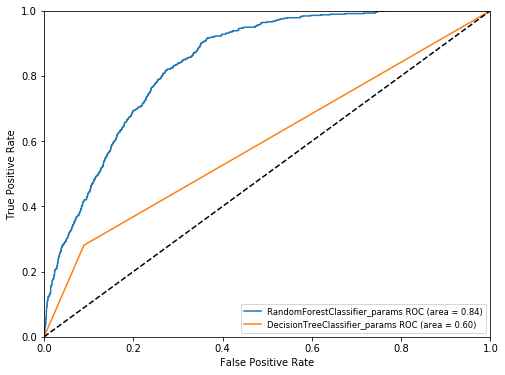

In [158]:
# ROC
from sklearn import model_selection
from sklearn.metrics import roc_curve, auc
roc_train_all, roc_test_all, roc_train_all_class, roc_test_all_class = train_test_split(
                                                                    features,
                                                                    labels,
                                                                    test_size = 0.25,
                                                                    random_state=42)
models = [

    {
        'label' : 'RandomForestClassifier_params',
        'model': clf_forest,
        'roc_train': roc_train_all,
        'roc_test': roc_test_all,
        'roc_train_class': roc_train_all_class,        
        'roc_test_class': roc_test_all_class, 
    },
    {
        'label' : 'DecisionTreeClassifier_params',
        'model': clf_decision,
        'roc_train': roc_train_all,
        'roc_test': roc_test_all,
        'roc_train_class': roc_train_all_class,        
        'roc_test_class': roc_test_all_class, 
    },
        
]

import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize=(8,6))

for m in models:
    m['model'].probability = True
    probas = m['model'].fit(m['roc_train'], m['roc_train_class']).predict_proba(m['roc_test'])
    fpr, tpr, thresholds = roc_curve(m['roc_test_class'], probas[:, 1])
    roc_auc  = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], roc_auc))



plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='small')
plt.show()

In [159]:
feature_imp_forest = pd.Series(clf_forest.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp_forest

symmetry    0.318949
border      0.275583
red         0.154049
blue        0.132711
green       0.118709
dtype: float64

In [160]:
feature_imp_decision = pd.Series(clf_decision.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp_decision

symmetry    0.243680
border      0.200343
red         0.187634
green       0.185339
blue        0.183004
dtype: float64